In [2]:
!git clone https://github.com/vsitzmann/siren.git

Cloning into 'siren'...
remote: Enumerating objects: 193, done.
remote: Total 193 (delta 0), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (193/193), 2.18 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [3]:
%cd siren

/content/siren


In [4]:
from modules import *

In [5]:
class ConvImgEncoder(nn.Module):
    def __init__(self, channel, image_resolution):
        super().__init__()

        # conv_theta is input convolution
        self.conv_theta = nn.Conv2d(channel, 128, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)

        self.cnn = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            Conv2dResBlock(256, 256),
            Conv2dResBlock(256, 256),
            Conv2dResBlock(256, 256),
            Conv2dResBlock(256, 256),
            nn.Conv2d(256, 256, 1, 1, 0)
        )

        self.relu_2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(784, 1)

        self.image_resolution = image_resolution

    def forward(self, I):
        o = self.relu(self.conv_theta(I))
        o = self.cnn(o)

        o = self.fc(self.relu_2(o).view(o.shape[0], 256, -1)).squeeze(-1)
        return o

In [6]:
net_ = ConvImgEncoder(1, 28)

In [7]:
net_(torch.ones((1, 1, 28, 28))).shape

torch.Size([1, 256])

In [8]:
'''Modules for hypernetwork experiments, Paper Sec. 4.4
'''

import torch
from torch import nn
from collections import OrderedDict
import modules


class HyperNetwork(nn.Module):
    def __init__(self, hyper_in_features, hyper_hidden_layers, hyper_hidden_features, hypo_module):
        '''

        Args:
            hyper_in_features: In features of hypernetwork
            hyper_hidden_layers: Number of hidden layers in hypernetwork
            hyper_hidden_features: Number of hidden units in hypernetwork
            hypo_module: MetaModule. The module whose parameters are predicted.
        '''
        super().__init__()

        hypo_parameters = hypo_module.meta_named_parameters()

        self.names = []
        self.nets = nn.ModuleList()
        self.param_shapes = []
        for name, param in hypo_parameters:
            self.names.append(name)
            self.param_shapes.append(param.size())

            hn = modules.FCBlock(in_features=hyper_in_features, out_features=int(torch.prod(torch.tensor(param.size()))),
                                 num_hidden_layers=hyper_hidden_layers, hidden_features=hyper_hidden_features,
                                 outermost_linear=True, nonlinearity='relu')
            self.nets.append(hn)

            if 'weight' in name:
                self.nets[-1].net[-1].apply(lambda m: hyper_weight_init(m, param.size()[-1]))
            elif 'bias' in name:
                self.nets[-1].net[-1].apply(lambda m: hyper_bias_init(m))

    def forward(self, z):
        '''
        Args:
            z: Embedding. Input to hypernetwork. Could be output of "Autodecoder" (see above)

        Returns:
            params: OrderedDict. Can be directly passed as the "params" parameter of a MetaModule.
        '''
        params = OrderedDict()
        for name, net, param_shape in zip(self.names, self.nets, self.param_shapes):
            batch_param_shape = (-1,) + param_shape
            params[name] = net(z).reshape(batch_param_shape)
        return params


class NeuralProcessImplicit2DHypernet(nn.Module):
    '''A canonical 2D representation hypernetwork mapping 2D coords to out_features.'''
    def __init__(self, in_features, out_features, image_resolution=None, encoder_nl='sine'):
        super().__init__()

        latent_dim = 256
        self.hypo_net = modules.SingleBVPNet(out_features=out_features, type='sine', sidelength=image_resolution,
                                             in_features=2)
        self.hyper_net = HyperNetwork(hyper_in_features=latent_dim, hyper_hidden_layers=3, hyper_hidden_features=256,
                                      hypo_module=self.hypo_net)
        self.set_encoder = modules.SetEncoder(in_features=in_features, out_features=latent_dim, num_hidden_layers=2,
                                              hidden_features=latent_dim, nonlinearity=encoder_nl)
        print(self)

    def freeze_hypernet(self):
        for param in self.hyper_net.parameters():
            param.requires_grad = False

    def get_hypo_net_weights(self, model_input):
        pixels, coords = model_input['img_sub'], model_input['coords_sub']
        ctxt_mask = model_input.get('ctxt_mask', None)
        embedding = self.set_encoder(coords, pixels, ctxt_mask=ctxt_mask)
        hypo_params = self.hyper_net(embedding)
        return hypo_params, embedding

    def forward(self, model_input):
        if model_input.get('embedding', None) is None:
            pixels, coords = model_input['img_sub'], model_input['coords_sub']
            ctxt_mask = model_input.get('ctxt_mask', None)
            embedding = self.set_encoder(coords, pixels, ctxt_mask=ctxt_mask)
        else:
            embedding = model_input['embedding']
        hypo_params = self.hyper_net(embedding)

        model_output = self.hypo_net(model_input, params=hypo_params)
        return {'model_in':model_output['model_in'], 'model_out':model_output['model_out'], 'latent_vec':embedding,
                'hypo_params':hypo_params}


class ConvolutionalNeuralProcessImplicit2DHypernet(nn.Module):
    def __init__(self, in_features, out_features, image_resolution=28, partial_conv=False):
        super().__init__()
        latent_dim = 256

        if partial_conv:
            self.encoder = modules.PartialConvImgEncoder(channel=in_features, image_resolution=image_resolution)
        else:
            self.encoder = ConvImgEncoder(channel=in_features, image_resolution=image_resolution)
        self.hypo_net = modules.FCBlock(2, 1, 3, 256, outermost_linear=True, nonlinearity='sine', weight_init=None)
        self.hyper_net = HyperNetwork(hyper_in_features=latent_dim, hyper_hidden_layers=1, hyper_hidden_features=256,
                                      hypo_module=self.hypo_net)

    def forward(self, model_input):
        if model_input.get('embedding', None) is None:
            embedding = self.encoder(model_input['img_sparse'])
        else:
            embedding = model_input['embedding']
        hypo_params = self.hyper_net(embedding)

        model_output = self.hypo_net(model_input["coords"], params=hypo_params)

        return {'model_out': model_output, 'latent_vec': embedding,
                'hypo_params': hypo_params}

    def get_hypo_net_weights(self, model_input):
        embedding = self.encoder(model_input['img_sparse'])
        hypo_params = self.hyper_net(embedding)
        return hypo_params, embedding

    def freeze_hypernet(self):
        for param in self.hyper_net.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False


############################
# Initialization schemes
def hyper_weight_init(m, in_features_main_net):
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')
        m.weight.data = m.weight.data / 1.e2

    if hasattr(m, 'bias'):
        with torch.no_grad():
            m.bias.uniform_(-1/in_features_main_net, 1/in_features_main_net)


def hyper_bias_init(m):
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')
        m.weight.data = m.weight.data / 1.e2

    if hasattr(m, 'bias'):
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        with torch.no_grad():
            m.bias.uniform_(-1/fan_in, 1/fan_in)

In [9]:
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1, shuffle=True)

In [ ]:
print(mnist_trainset[0][0])

<PIL.Image.Image image mode=L size=28x28 at 0x7F3A093B1810>


In [11]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [12]:
from torch.utils.data import DataLoader, Dataset

class ImageFitting(Dataset):
    def __init__(self, sidelength, img):
        super().__init__()
        print(img.shape)
        self.pixels = img.view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [13]:
import numpy as np
cameraman = ImageFitting(28, torch.Tensor(np.array(mnist_trainset[0][0])))
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

torch.Size([28, 28])


In [14]:
img_siren = modules.FCBlock(2, 1, 3, 128, outermost_linear=True, nonlinearity='sine', weight_init=None)
img_siren.cuda()

RuntimeError: ignored

In [15]:
import matplotlib.pyplot as plt

In [ ]:
total_steps = 100000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-5, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    # model_output = net({'img_sparse': ground_truth.view((1, 1, 28, 28)).cuda(), 'coords': model_input.cuda()})["model_out"]
    model_output = img_siren(model_input)
    loss = ((model_output.cuda() - (ground_truth / 255))**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        print(torch.max(model_output))
        print(torch.max(ground_truth))

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(28,28).detach().numpy())
        axes[1].imshow((ground_truth / 255).cpu().view(28,28).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

In [ ]:
total_steps = 1000000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-6, params=net.hyper_net.parameters())

# model_input, ground_truth = get_mgrid(28, 2), torch.Tensor(np.array(mnist_trainset[step % len(mnist_trainset)][0])).reshape((784, 1))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    
    out = net({'embedding': ground_truth.view((1, 784)).cuda(), 'coords': model_input.cuda()})
    model_output = nn.Sigmoid()(out["model_out"])
    hypo_params = out["hypo_params"]
    all_hypo_params = torch.cat([x.view(-1) for x in list(hypo_params.values())])
    # model_output, coords = img_siren(model_input)    
    loss = ((model_output.cuda() - (ground_truth / 255))**2).mean() + 1000 * ((all_hypo_params.cuda())**2).mean()
    
    if not step % 250:
        print("Step %d, Total loss %0.6f" % (step, loss))

        print(torch.max(model_output))
        print(torch.max(ground_truth))

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(28,28).detach().numpy())
        axes[1].imshow((ground_truth / 255).cpu().view(28,28).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

NameError: ignored

In [ ]:
net = ConvolutionalNeuralProcessImplicit2DHypernet(1, 1, image_resolution=28)
net.cuda()

ConvolutionalNeuralProcessImplicit2DHypernet(
  (encoder): ConvImgEncoder(
    (conv_theta): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (cnn): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2dResBlock(
        (convs): Sequential(
          (0): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (3): ReLU()
        )
        (final_relu): ReLU()
      )
      (3): Conv2dResBlock(
        (convs): Sequential(
          (0): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (3): ReLU()
        )
        (final_relu): ReLU()
      )
      (4): Conv2dResBlock(
        (convs): Sequential(
        

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [ ]:
loader = DataLoader(MNISTSirenDataset(mnist_trainset), batch_size=32, shuffle=True)

Step 0, Total loss 4.810392
tensor(4.5554, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(255., device='cuda:0')


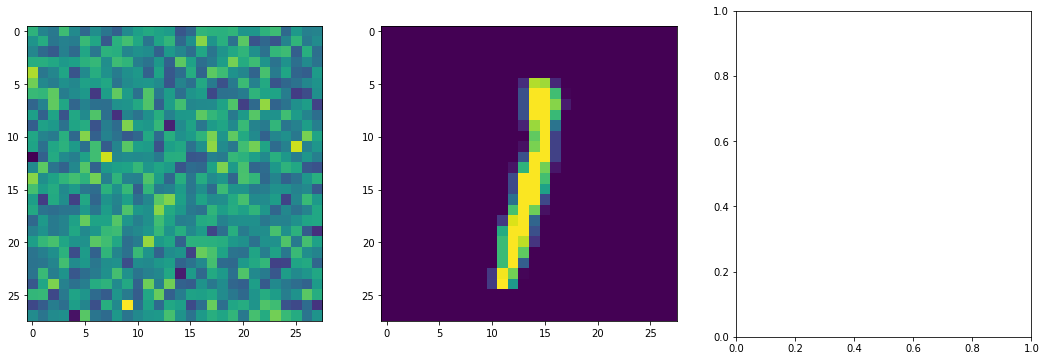

KeyboardInterrupt: ignored

In [ ]:
total_steps = 1000000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50
batch_size = 8

optim = torch.optim.Adam(lr=5e-5, params=[
                            {'params': net.hyper_net.parameters()},
                            {'params': net.encoder.parameters()}
                        ])

for e in range(100):
  for i, (img, coords) in enumerate(loader):
      
      # model_input, ground_truth = coords# get_mgrid(28, 2), torch.Tensor(np.array(mnist_trainset[step % len(mnist_trainset)][0])).reshape((784, 1))
      # model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
      img, coords = img.cuda(), coords.cuda()

      out = net({'img_sparse': img.view((32, 1, 28, 28)).cuda(), 'coords': coords.cuda()})

      model_output = out["model_out"]
      embedding = out["latent_vec"]
      hypo_params = out["hypo_params"]

      all_hypo_params = torch.cat([x.view(-1) for x in list(hypo_params.values())])

      loss = ((model_output.cuda() - (img / 255))**2).mean() + 0.1 * ((embedding.cuda())**2).mean() + 100 * ((all_hypo_params.cuda())**2).mean()
      
      if not i % 250:
          print("Step %d, Total loss %0.6f" % (i, loss))

          print(torch.max(model_output))
          print(torch.max(img))

          fig, axes = plt.subplots(1,3, figsize=(18,6))
          axes[0].imshow((model_output[0]).cpu().view(28,28).detach().numpy())
          axes[1].imshow((img / 255)[0].cpu().view(28,28).detach().numpy())
          plt.show()

      optim.zero_grad()
      loss.backward()
      optim.step()

In [ ]:
# torch.save(net.state_dict(), "mnist_siren")

In [ ]:
total_steps = 1000000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50
batch_size = 8

optim = torch.optim.Adam(lr=5e-5, params=[
                            {'params': net_2.hyper_net.parameters()},
                            {'params': net_2.encoder.parameters()}
                        ])

for e in range(100):
  for i, (img, coords) in enumerate(loader):
      
      # model_input, ground_truth = coords# get_mgrid(28, 2), torch.Tensor(np.array(mnist_trainset[step % len(mnist_trainset)][0])).reshape((784, 1))
      # model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
      img, coords = img.cuda(), coords.cuda()

      out = net_2({'img_sparse': img.view((32, 1, 28, 28)).cuda(), 'coords': coords.cuda()})

      model_output = out["model_out"]
      embedding = out["latent_vec"]
      hypo_params = out["hypo_params"]

      all_hypo_params = torch.cat([x.view(-1) for x in list(hypo_params.values())])

      loss = ((model_output.cuda() - (img / 255))**2).mean() + 0.1 * ((embedding.cuda())**2).mean() + 100 * ((all_hypo_params.cuda())**2).mean()
      
      if not i % 250:
          print("Step %d, Total loss %0.6f" % (i, loss))

          print(torch.max(model_output))
          print(torch.max(img))

          fig, axes = plt.subplots(1,3, figsize=(18,6))
          axes[0].imshow((model_output[0]).cpu().view(28,28).detach().numpy())
          axes[1].imshow((img / 255)[0].cpu().view(28,28).detach().numpy())
          plt.show()

      optim.zero_grad()
      loss.backward()
      optim.step()

RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
net_2 = ConvolutionalNeuralProcessImplicit2DHypernet(1, 1, image_resolution=28)
net_2.cuda()
net_2.load_state_dict(torch.load("/content/drive/My Drive/mnist_siren"))

<All keys matched successfully>

In [ ]:
class MNISTSirenDataset(torch.utils.data.Dataset):
    def __init__(self, trainMNIST):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trainMNIST = trainMNIST

    def __len__(self):
        return len(self.trainMNIST)

    def __getitem__(self, idx):
        image = torch.Tensor(np.array(self.trainMNIST[idx][0])).reshape((784, 1))
        coord = get_mgrid(28, 2)

        return image, coord

In [ ]:
class MNISTSirenDataset(torch.utils.data.Dataset):
    def __init__(self, trainMNIST, upsample=1):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trainMNIST = trainMNIST
        self.upsample = upsample

    def __len__(self):
        return len(self.trainMNIST)

    def __getitem__(self, idx):
        image = torch.Tensor(np.array(self.trainMNIST[idx][0])).reshape((784, 1))

        coord = get_mgrid(28 * self.upsample, 2)
                            
        return image, coord

torch.Size([1, 256])


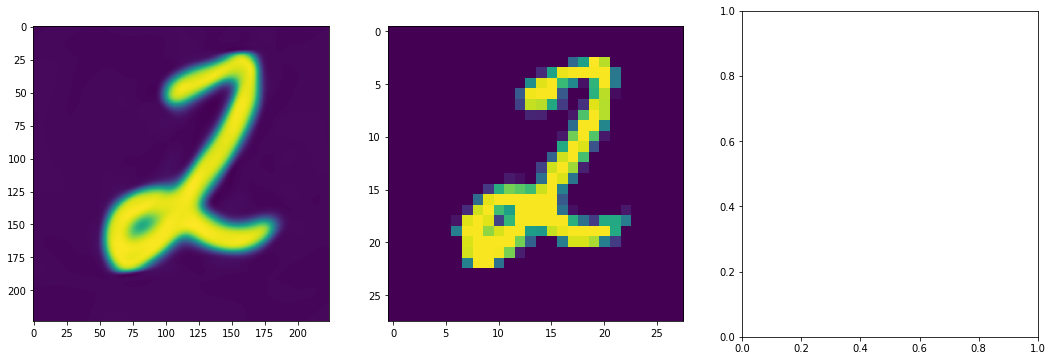

In [ ]:
loader = DataLoader(MNISTSirenDataset(mnist_testset, upsample=8), batch_size=1, shuffle=True)
for i, (img, coords) in enumerate(loader):
  img, coords = img.cuda(), coords.cuda()
  img_ = img.view((1, 1, 28, 28)).cuda()
  # img_[:, :, 5:9, 15:20] = img.mean() # * torch.randn(4, 5).cuda()
  # img_ = torch.clip(img_, 0, 255)
  # print(img.max())
  # img += 5 * torch.randn_like(img)
  out = net_2({'img_sparse': img.view((1, 1, 28, 28)).cuda(), 'coords': coords.cuda()})

  model_output = out["model_out"]
  embedding = out["latent_vec"]
  hypo_params = out["hypo_params"]

  print(hypo_params["net.2.0.bias"].shape)

  fig, axes = plt.subplots(1,3, figsize=(18,6))
  axes[0].imshow((model_output[0]).cpu().view(28*8,28*8).detach().numpy())
  axes[1].imshow((img / 255)[0].cpu().view(28,28).detach().numpy())
  plt.show()

  break